# Plot Single Physical Processes
Here you can plot heatmaps along two dimensions. You set the upper and lower boundaries for up to 
three different variables and the number of bins and equally sized bins are created, where for each
the desired process is run. The results are stored in a pandas dataframe.

To get started, make sure you created a binary using the Makefile.
You can alter the Makefile to your choice. \
The variable `SEASON` can be set to
`SPRING`, `SUMMER`, `AUTUMN`, `WINTER` and `SPRING95` and sets variables used
in Hande et al. nucleation (not used by default, so you can ignore it). \
With `FLUX` the microphysics takes incoming particles from above into account (default: on).
Leave it empty, if you do not want to use it. \
`SOURCE` is used to toggle different input files (default is `WCB2`; just leave it with that).
`SAT_CALC` is set in `SOURCE` as well to calculate the saturation at every step using `qv*Rv*T/p_sat`
with `Rv` the gas constant for water vapor and `p_sat` the
saturation vapor pressure over a flat surface of liquid water (see `physical_parametrizations.h`).
If it is not on, then saturation of 1 is assumed.

To compile the code, simply type
```
make scan
```
and your binary is under `build/apps/src/scratch/scan`.

Next we setup the data

In [105]:
from io import StringIO
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import subprocess as sb
from matplotlib import rcParams
from matplotlib.colors import LogNorm
import numpy as np

# figure size in inches
rcParams['figure.figsize'] = (16,10)

# Possible parameters that may be used. Change them to your liking
pressure = 1000.0 # [Pascal]
temperature = 280.0 # [Kelvin]
ascent = 0.1 # ascent rate [m/s]
qv = 1e-5
qc = 1e-5
qr = 1e-5
qs = 1e-5
qi = 1e-5
qh = 1e-5
qg = 1e-5
temp_crit = 270.0
n_inact = 0 # Number of inactive nuclei
x_i = 1e-7 # mean ice mass [1/g^3]
D_i = 1e-7 # mean ice diameter [1/cm^3]
dep_snow = 1 # deposition rate of snow
dep_ice = 1
# riming rates
rime_qc = 1 
rime_qr = 1
rime_qi = 1
rime_qs = 1
height = 2000

# Possible lower and upper limits for each variable that may be used
# Note: critical values for ie riming is q > 1.0e-7
p_min = 1000.0
p_max = 200.0 
temp_min = 180.0
temp_max = 320.0
ascent_min = 0.0
ascent_max = 0.1
qv_min = 0.0
qv_max = 1e-2
qc_min = 0.0
qc_max = 1e-2
qr_min = 0.0
qr_max = 1e-2
qs_min = 0.0
qs_max = 1e-2
qi_min = 0.0
qi_max = 1e-2
qh_min = 0.0
qh_max = 1e-2
qg_min = 0.0
qg_max = 1e-2
n_inact_min = 0
n_inact_max = 1e12
x_i_min = 1e-15
x_i_max = 1e-1
D_i_min = 1e-15
D_i_max = 1e-1
dep_snow_min = 0
dep_snow_max = 1
dep_ice_min = 0
dep_ice_max = 1
rime_qc_min = 0 
rime_qr_min = 0
rime_qi_min = 0
rime_qs_min = 0
rime_qc_max = 1 
rime_qr_max = 1
rime_qi_max = 1
rime_qs_max = 1
height_min = 0
height_max = 20000

# Number of bins along each dimension
n1 = 50
n2 = 50
n3 = 50

# Possible ways to test each function
# The key is the name of a function and the list
# contains of all the commandline arguments.
# Each parameter seen in this list can be 
# used either as exact values or with minimum *and* 
# maximum values.
method_dic = {"ccn_act_hande": ["--p_min", "{}".format(p_min),
                              "--p_max", "{}".format(p_max),
                              "--ascent_min", "{}".format(ascent_min),
                              "--ascent_max", "{}".format(ascent_max),
                              "--temperature", "{}".format(temperature),
                              "--qv", "{}".format(qv),
                              "--qc", "{}".format(qc)],
              "ccn_act_seifert": ["--qv_min", "{}".format(qv_min),
                              "--qv_max", "{}".format(qv_max),
                              "--pressure", "{}".format(pressure),
                              "--temp_min", "{}".format(240), 
                              "--temp_max", "{}".format(280),
                              "--height_min", "{}".format(height_min), 
                              "--height_max", "{}".format(height_max),
                              "--qc", "{}".format(qc),
                              "--qr", "{}".format(qr),
                              "--ascent", "{}".format(ascent)], 
              "ice_nuc_hom": ["--p_min", "{}".format(p_min),
                              "--p_max", "{}".format(p_max),
                              "--temp_min", "{}".format(150), 
                              "--temp_max", "{}".format(215),
                              "--ascent", "{}".format(ascent),
                              "--qv", "{}".format(qv),
                              "--qi", "{}".format(qi)], 
              "ice_activation_hande": ["--temp_min", "{}".format(178), 
                              "--temp_max", "{}".format(270),
                              "--qc_min", "{}".format(qc_min),
                              "--qc_max", "{}".format(qc_max),
                              "--qv_min", "{}".format(qv_min),
                              "--qv_max", "{}".format(qv_max),
                              "--n_inact", "{}".format(n_inact)], 
              "ice_activation_phillips": ["--temp_min", "{}".format(178), 
                              "--temp_max", "{}".format(270),
                              "--qc_min", "{}".format(qc_min),
                              "--qc_max", "{}".format(qc_max),
                              "--qv_min", "{}".format(qv_min),
                              "--qv_max", "{}".format(qv_max),
                              "--n_inact", "{}".format(n_inact)], 
              "cloud_freeze_hom": [], # qc, temperature, critical temperature
              "ice_self_collection": [], # qi, mean ice mass, mean ice diameter, critical temperature
              "snow_self_collection": [], # qs, temperature
              "graupel_melting": [], # qg, temperature
              "hail_melting": [], # qh, temperature
              "auto_conversion_kb": [], # qc, qr
              "auto_conversion_sb": [], # qc, qr 
              "rain_self_collection_sb": [], # qr
              "rain_evaporation_sb": [], # qr, qv, temperature, pressure
              "sedimentation_explicit": [], # qc, qr, qs, qi, qh, qg, pressure
              "evaporation": [], # qv, temperature, mixing ratio of ice particle
              "vapor_dep_relaxation": [], # qv, qi, qs, qg, qh, temperature
              "particle_collection": [], # mixing ratio of particle 1 and 2, critical temperature
              "particle_particle_collection": [], # qi, qs, qg, temperature, critical temperature
              "graupel_hail_conv": [], # qc, qr, qi, qg, qh, pressure, temperature, critical temperature
              "hail_collision": [], # qh, qs, qi, critical temperature
              "riming_cloud_core": [], # qc, mixing ratio of ice or snow
              "riming_rain_core": [], # qr, mixing ratio of another particle
              "ice_riming": [], # qc, qr, qi, deposition rate of ice, riming rates of qc, qr, qi, temperature
              "snow_riming": [], # qc, qr, qs, deposition rate of snow, riming rates of qc, qr, qs, temperature
              # qc, temperature, mixing ratio of second particle (hail or graupel), pressure and water vapor
              # for saturation and vertical velocities
              "particle_cloud_riming": ["--temp_min", "{}".format(temp_min), 
                              "--temp_max", "{}".format(temp_max),
                              "--qc_min", "{}".format(qr_min),
                              "--qc_max", "{}".format(qr_max),
                              "--qh_min", "{}".format(qh_min),
                              "--qh_max", "{}".format(qh_max),
                              "--pressure", "{}".format(pressure),
                              "--qv", "{}".format(qv)],
              # qr, temperature, mixing ratio of second particle (hail or graupel), pressure and water vapor
              # for saturation and vertical velocities
              "particle_rain_riming": ["--temp_min", "{}".format(temp_min), 
                              "--temp_max", "{}".format(temp_max),
                              "--qr_min", "{}".format(qr_min),
                              "--qr_max", "{}".format(qr_max),
                              "--qh_min", "{}".format(qh_min),
                              "--qh_max", "{}".format(qh_max),
                              "--pressure", "{}".format(pressure),
                              "--qv", "{}".format(qv)], 
              "rain_freeze": ["--temp_min", "{}".format(temp_min), 
                              "--temp_max", "{}".format(temp_max),
                              "--qr_min", "{}".format(qr_min),
                              "--qr_max", "{}".format(qr_max)], 
              "ice_melting": ["--temp_min", "{}".format(temp_min), 
                              "--temp_max", "{}".format(temp_max),
                              "--qi_min", "{}".format(qi_min),
                              "--qi_max", "{}".format(qi_max)], 
             }

We define basic functions as example on how to execute the simulation
and read the data

In [40]:
def read_data(x, y, d1, d2, d3, method, n1, n2, n3):
    completed = sb.run(
    ["build/apps/src/scratch/scan", "--function", method, 
     "--n1", "{}".format(n1), "--n2", "{}".format(n2), "--n3", "{}".format(n3)] 
    +  method_dic[method],
    capture_output=True,
    encoding="utf-8")
    df = pd.read_csv(StringIO(completed.stdout), sep=",")
    df[d1] = df.groupby([x, y])[d1].transform('sum')
    df[d2] = df.groupby([x, y])[d2].transform('sum')
    df[d3] = df.groupby([x, y])[d3].transform('sum')
    df = df.drop_duplicates(subset=[x, y])
    #     df.describe() # <- can be used to get some statistics
    return df


This is a basic function to plot three heatmaps with up to two colorbars
i.e. for plotting two heatmaps with mixing ratios and one heatmap with
change in latent heating

In [101]:
def plot(x, y, d1, d2, d3, method, n1, n2, n3, title1, title2, title3, 
         df=None, x_format=":.1e", y_format=":.1e", sep_bar=False,
         cbar_label1="change in mixing ratio",
         cbar_label2="change in latent heat/cool"):
    if df is None:
        df = read_data(x, y, d1, d2, d3, method, n1, n2, n3)
    sns.set(rc={'figure.figsize':(16,20)})
    cmap = "viridis"

    dx = (df[x].max() - df[x].min()) / len(df[x].unique())
    dy = (df[y].max() - df[y].min()) / len(df[y].unique())
    vmin = df[d1].min()
    if df[d2].min() < vmin:
        vmin = df[d2].min()
    if df[d3].min() < vmin and not sep_bar:
        vmin = df[d3].min()

    vmax = df[d1].max()
    if df[d2].max() > vmax:
        vmax = df[d2].max()
    if df[d3].max() > vmax and not sep_bar:
        vmax = df[d3].max()

    fig, axes = plt.subplots(nrows=3, ncols=1)
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    fig.subplots_adjust(right=0.8)
    if sep_bar:
        cbar_ax = fig.add_axes([0.85, 0.4, 0.05, 0.48])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # fake up the array of the scalar mappable. Urgh…
        sm._A = []
        clb = plt.colorbar(sm, cax=cbar_ax)
        clb.set_label(cbar_label1)
        
        cbar_ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.25])
        sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # fake up the array of the scalar mappable. Urgh…
        sm2._A = []
        clb2 = plt.colorbar(sm2, cax=cbar_ax2)
        clb2.set_label(cbar_label2)
    else:
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # fake up the array of the scalar mappable. Urgh…
        sm._A = []
        clb = plt.colorbar(sm, cax=cbar_ax)
        clb.set_label(cbar_label1)

    sns.heatmap(df.pivot(y, x, d1), cbar=False, ax=ax1, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=False, yticklabels=n2//5)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y_v, pos: ("{" + y_format + "}").format(y_v*dy+df[y].min())))
    ax1.set_title(title1)

    sns.heatmap(df.pivot(y, x, d2), cbar=False, ax=ax2, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=False, yticklabels=n2//5)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y_v, pos: ("{" + y_format + "}").format(y_v*dy+df[y].min())))
    ax2.set_title(title2)
    
    if sep_bar:
        sns.heatmap(df.pivot(y, x, d3), cbar=False, ax=ax3,
                    cmap=cmap, xticklabels=n1//10, yticklabels=n2//5)
    else:
        sns.heatmap(df.pivot(y, x, d3), cbar=False, ax=ax3, vmin=vmin, vmax=vmax,
                    cmap=cmap, xticklabels=n1//10, yticklabels=n2//5)
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x_v, pos: ("{" + x_format + "}").format(x_v*dx+df[x].min())))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y_v, pos: ("{" + y_format + "}").format(y_v*dy+df[y].min())))
    ax3.set_title(title3)

    plt.subplots_adjust(hspace=0.2)
    plt.show()

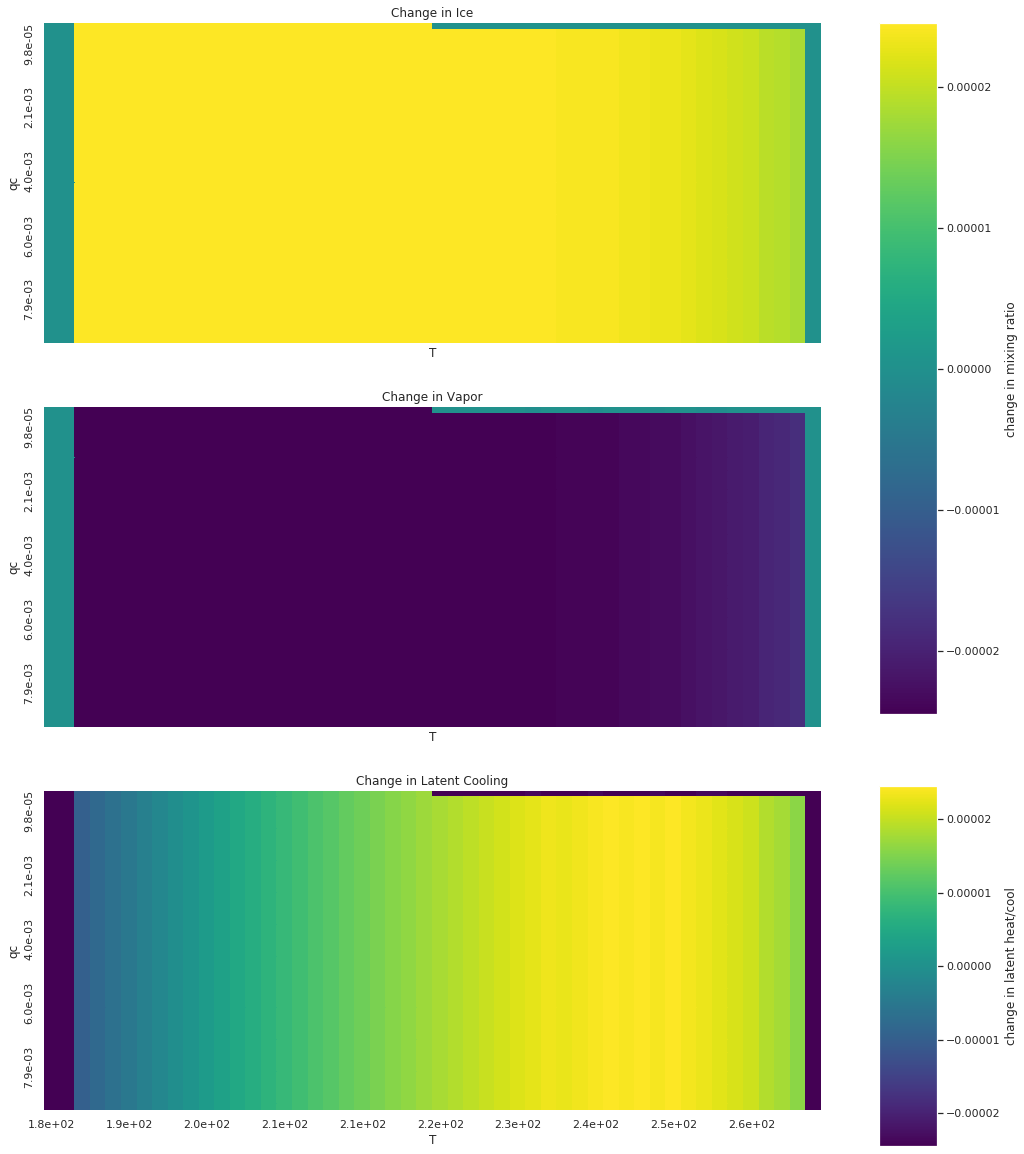

In [106]:
plot(
    x="T",
    y="qc",
    d1="delta_qi",
    d2="delta_qv",
    d3="delta_lat_cool",
    n1=50,
    n2=50,
    n3=50,
    method="ice_activation_phillips",
    title1="Change in Ice",
    title2="Change in Vapor",
    title3="Change in Latent Cooling",
    sep_bar=True,
    x_format=":.1e")

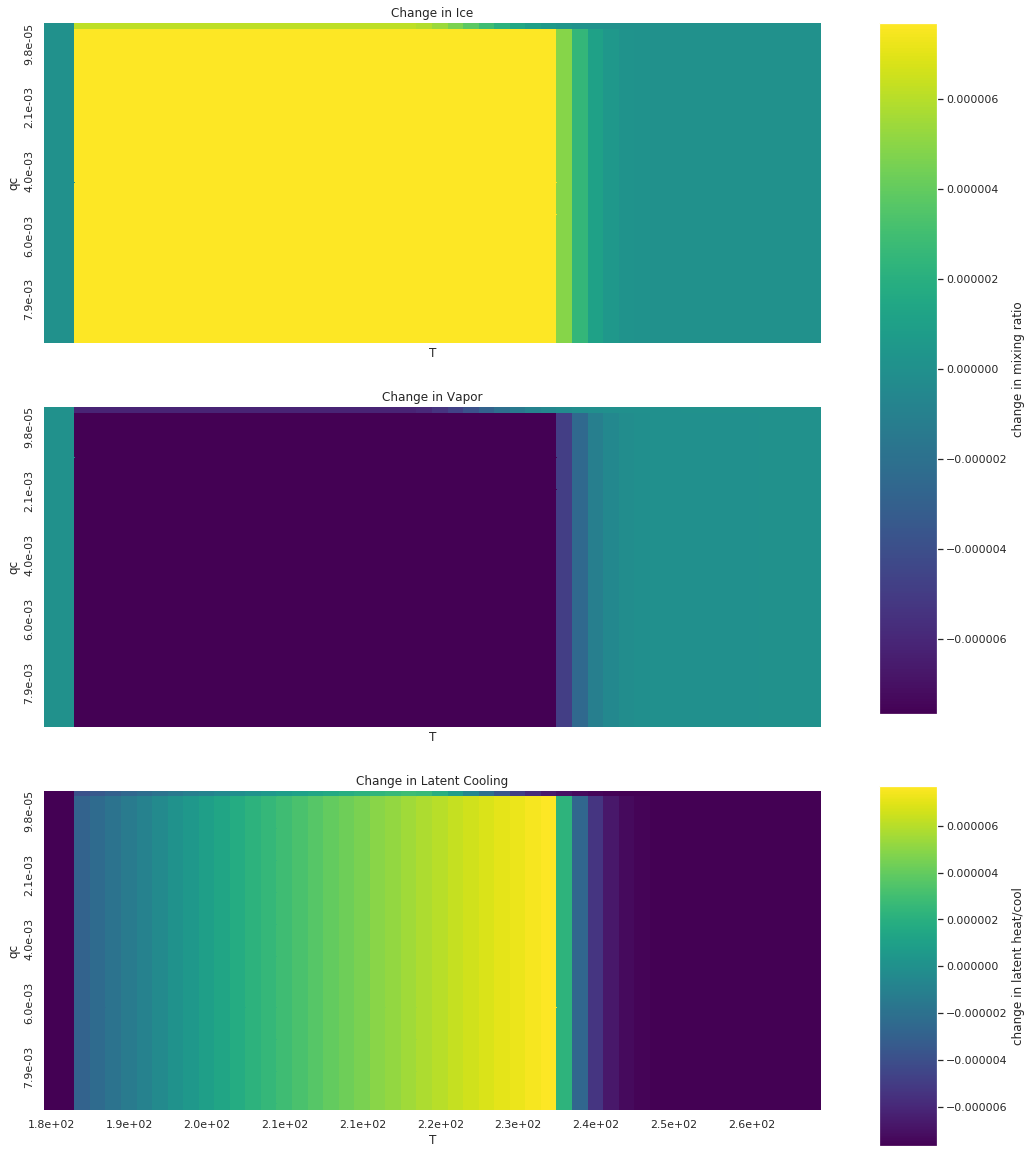

In [103]:
plot(
    x="T",
    y="qc",
    d1="delta_qi",
    d2="delta_qv",
    d3="delta_lat_cool",
    n1=50,
    n2=50,
    n3=50,
    method="ice_activation_hande",
    title1="Change in Ice",
    title2="Change in Vapor",
    title3="Change in Latent Cooling",
    sep_bar=True,
    x_format=":.1e")

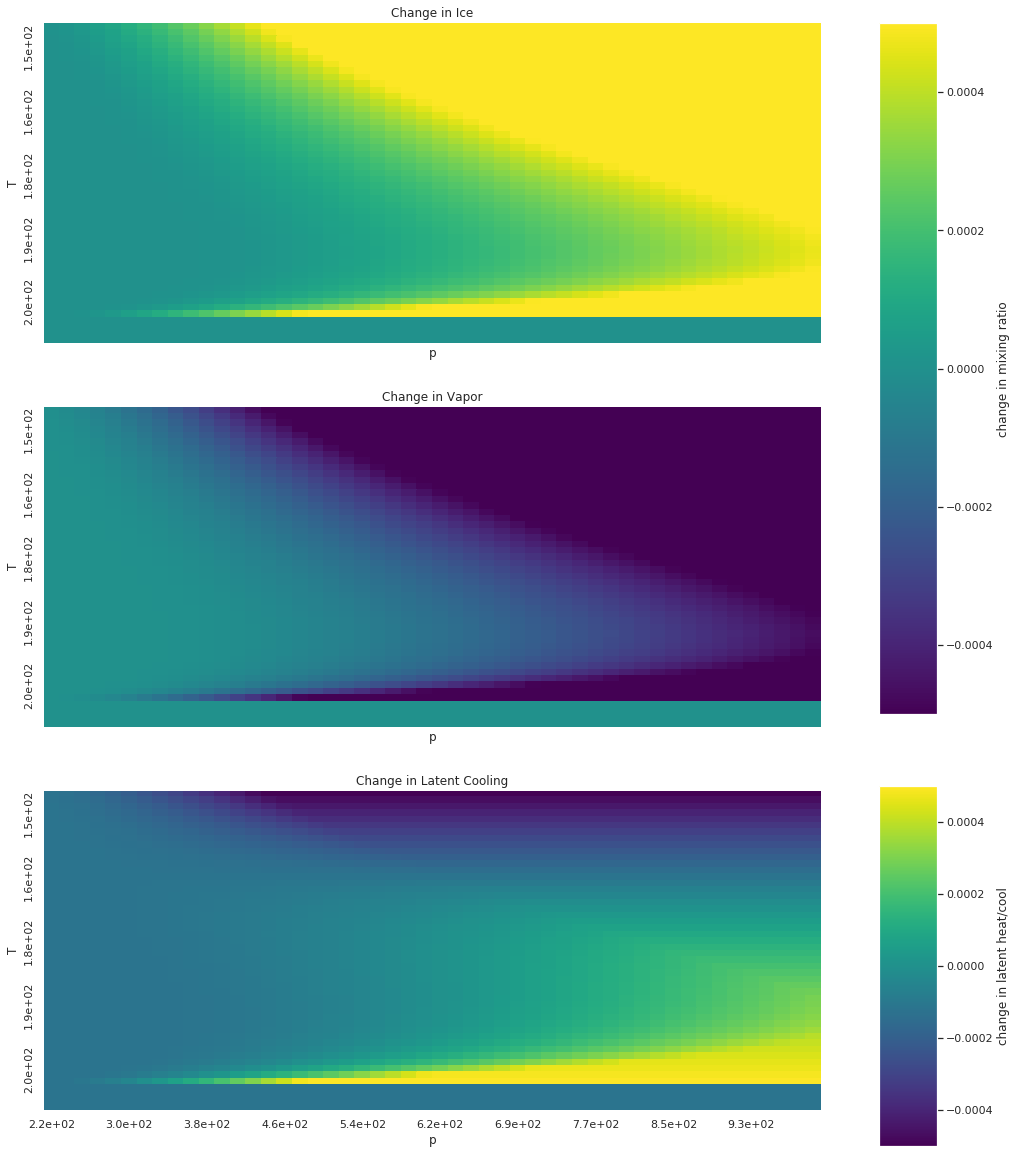

In [90]:
plot(
    x="p",
    y="T",
    d1="delta_qi",
    d2="delta_qv",
    d3="delta_lat_cool",
    n1=50,
    n2=50,
    n3=50,
    method="ice_nuc_hom",
    title1="Change in Ice",
    title2="Change in Vapor",
    title3="Change in Latent Cooling",
    sep_bar=True,
    x_format=":.1e")

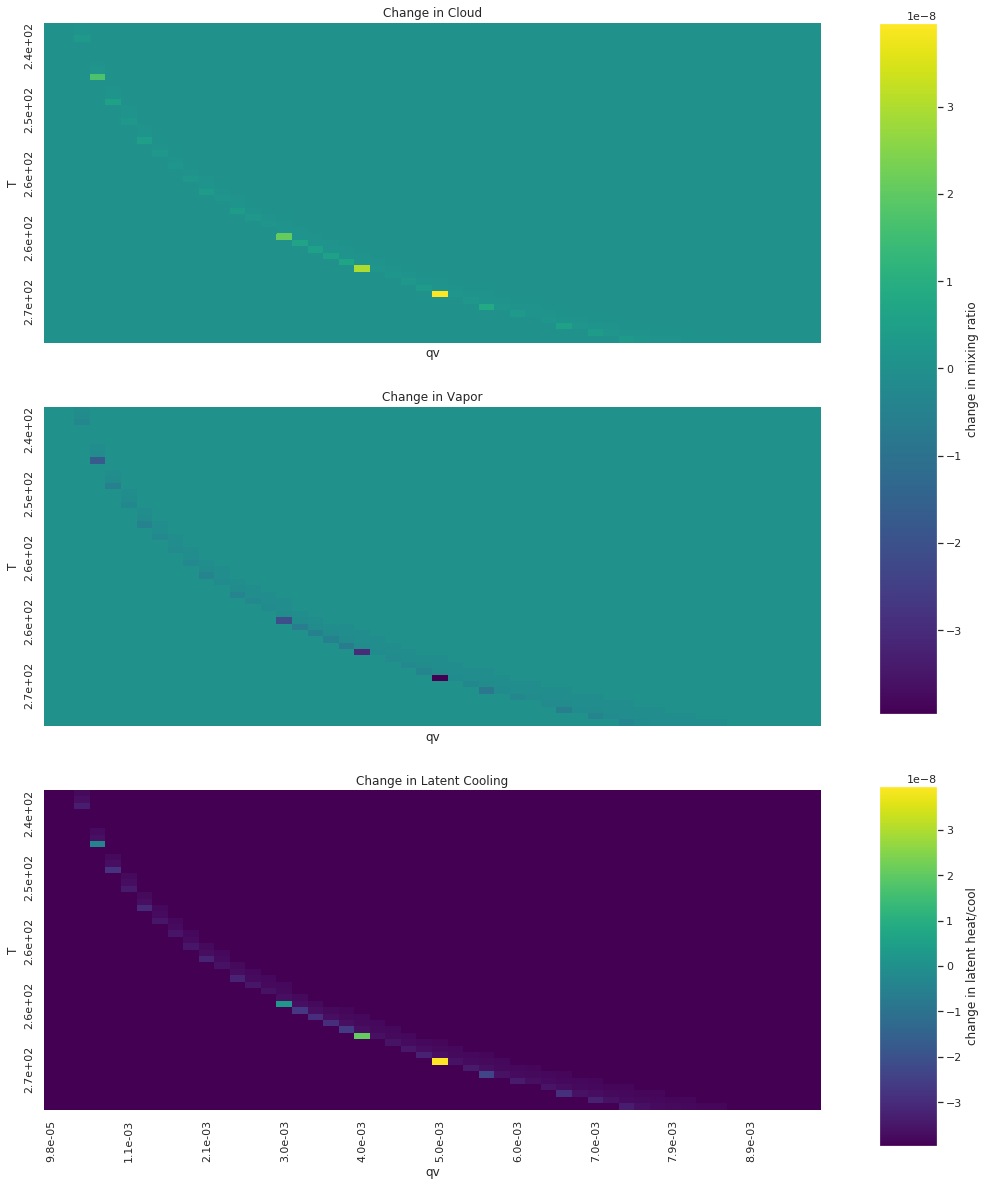

In [82]:
plot(
    x="qv",
    y="T",
    d1="delta_qc",
    d2="delta_qv",
    d3="delta_lat_cool",
    n1=50,
    n2=50,
    n3=50,
    method="ccn_act_seifert",
    title1="Change in Cloud",
    title2="Change in Vapor",
    title3="Change in Latent Cooling",
    sep_bar=True,
    x_format=":.1e")

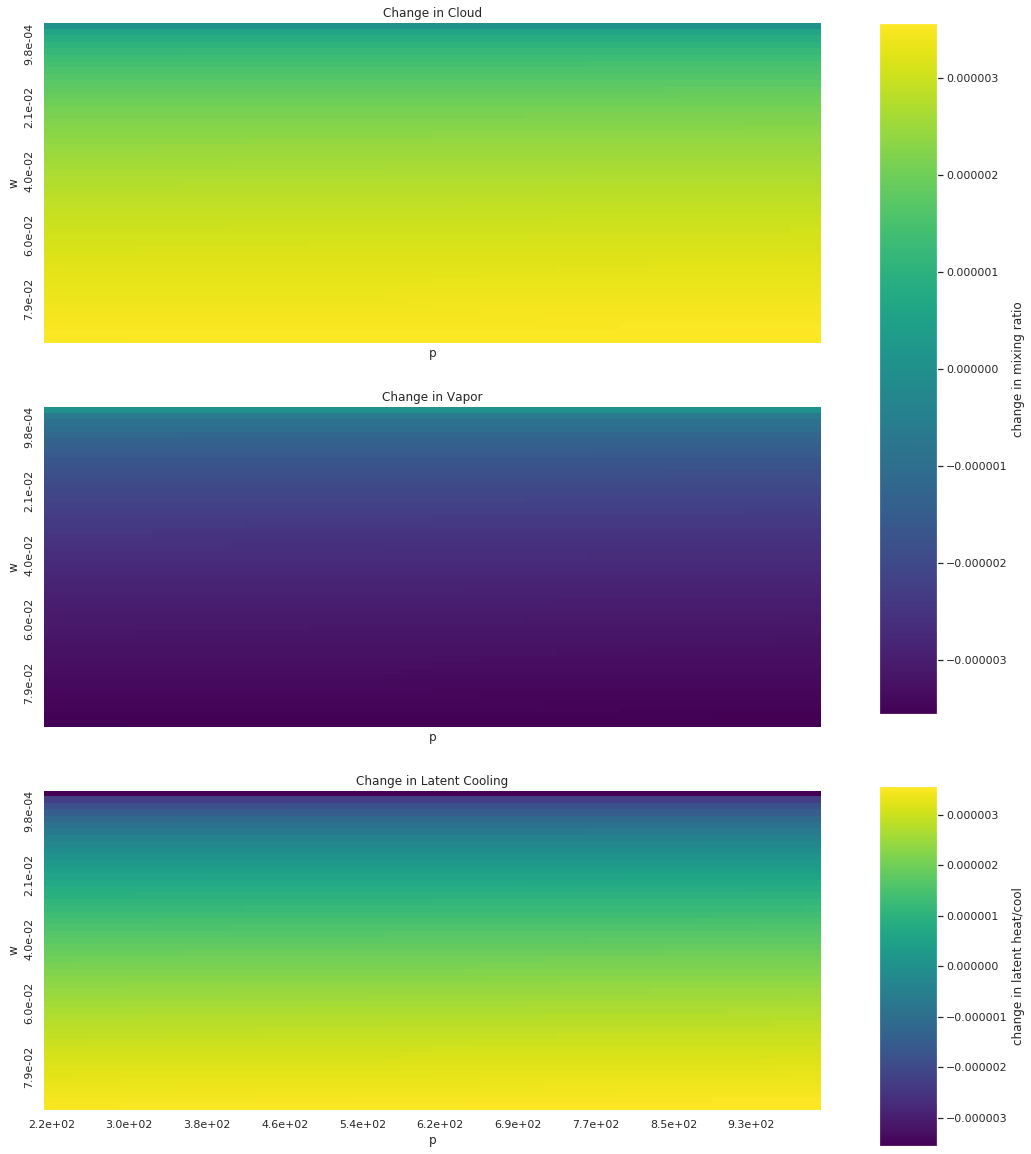

In [83]:
plot(
    x="p",
    y="w",
    d1="delta_qc",
    d2="delta_qv",
    d3="delta_lat_cool",
    n1=50,
    n2=50,
    n3=50,
    method="ccn_act_hande",
    title1="Change in Cloud",
    title2="Change in Vapor",
    title3="Change in Latent Cooling",
    sep_bar=True)

In [3]:
n1 = 2
n2 = 2
n3 = 2
x = "qc"
y = "T"
d1 = "delta_qc"
method = "particle_cloud_riming"
completed = sb.run(
    ["build/apps/src/scratch/scan", "--function", method, 
     "--n1", "{}".format(n1), "--n2", "{}".format(n2), "--n3", "{}".format(n3)] 
    +  method_dic[method],
    capture_output=True,
    encoding="utf-8")
print(completed.stdout)


qc,Nc,T,S,qv,delta_qc,delta_Nc,delta_qh,delta_Nh,delta_qi,delta_Ni,delta_qr,delta_Nr,delta_lat_cool,delta_lat_heat
0,0,180,95.5702,1e-05,0,0,0,0,0,0,0,0,0,0
0,0,180,95.5702,1e-05,0,0,0,0,0,0,0,0,0,0
0.005,3.84609e+07,180,95.5702,1e-05,0,0,0,0,0,0,0,0,0,0
0.005,3.84609e+07,180,95.5702,1e-05,-0.000282027,-2.16941e+06,0.000282027,0,0,0,0,0,0,0.0106118
0,0,250,0.0122189,1e-05,0,0,0,0,0,0,0,0,0,0
0,0,250,0.0122189,1e-05,0,0,0,0,0,0,0,0,0,0
0.005,3.84609e+07,250,0.0122189,1e-05,0,0,0,0,0,0,0,0,0,0
0.005,3.84609e+07,250,0.0122189,1e-05,-0.000322025,-2.47528e+06,0.000322025,0,0,0,0,0,0,0.0467752



In [10]:
n1 = 50
n2 = 50
n3 = 50
x = "qc"
y = "T"
d1 = "delta_qc"
method = "particle_cloud_riming"
completed = sb.run(
    ["build/apps/src/scratch/scan", "--function", method, 
     "--n1", "{}".format(n1), "--n2", "{}".format(n2), "--n3", "{}".format(n3)] 
    +  method_dic[method],
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df[d1] = df.groupby([x, y])[d1].transform('sum')
df["delta_qr"] = df.groupby([x, y])['delta_qr'].transform('sum')
df["delta_qh"] = df.groupby([x, y])['delta_qh'].transform('sum')
df = df.drop_duplicates(subset=[x, y])
df.describe()

,qc,Nc,T,S,qv,delta_qc,delta_Nc,delta_qh,delta_Nh,delta_qi,delta_Ni,delta_qr,delta_Nr,delta_lat_cool,delta_lat_heat
count,2500.000000,2.500000e+03,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.0,2500.000000,2500.0,2500.0,2500.0,2500.000000,2500.0,2500.0,2500.0
mean,0.004900,3.769170e+07,248.600000,4.899221,1.000000e-05,-0.015379,0.0,0.014033,0.0,0.0,0.0,0.001345,0.0,0.0,0.0
std,0.002887,2.220542e+07,40.414519,16.132909,3.405754e-19,0.009137,0.0,0.008518,0.0,0.0,0.0,0.002881,0.0,0.0,0.0
min,0.000000,0.000000e+00,180.000000,0.000160,1.000000e-05,-0.034047,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,0.002400,1.846120e+07,213.600000,0.001034,1.000000e-05,-0.023115,0.0,0.006743,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,0.004900,3.769170e+07,248.600000,0.013894,1.000000e-05,-0.015290,0.0,0.013756,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75%,0.007400,5.692220e+07,283.600000,0.525597,1.000000e-05,-0.007502,0.0,0.020981,0.0,0.0,0.0,0.000939,0.0,0.0,0.0
max,0.009800,7.538340e+07,317.200000,95.570200,1.000000e-05,0.000000,0.0,0.032017,0.0,0.0,0.0,0.016360,0.0,0.0,0.0


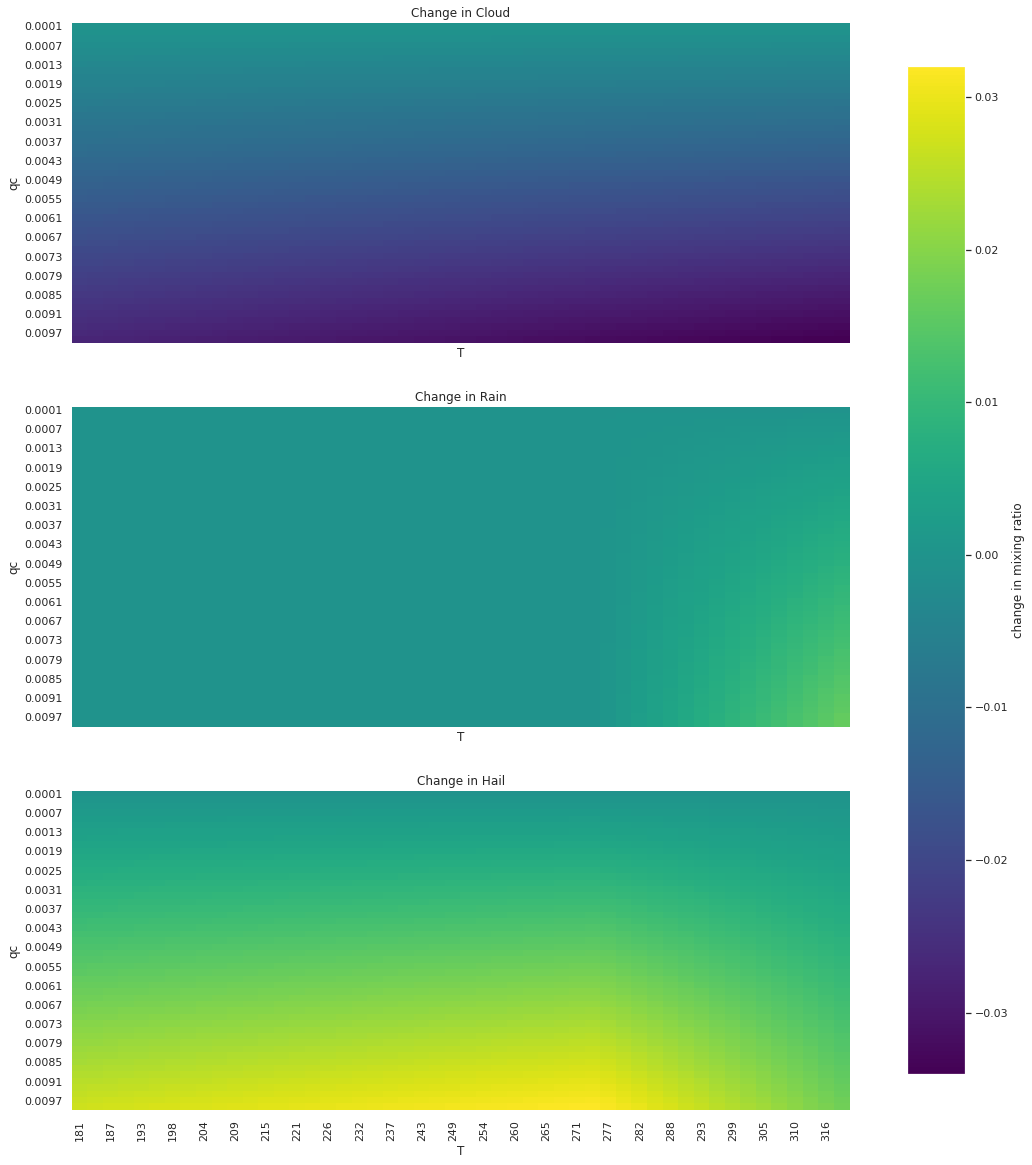

In [11]:
sns.set(rc={'figure.figsize':(16,20)})
cmap = "viridis"

dT = (temp_max - temp_min) / len(df[y].unique())
dqr = (qr_max - qr_min) / len(df[x].unique())
vmin = df[d1].min()
if df["delta_qr"].min() < vmin:
    vmin = df["delta_qr"].min()
if df["delta_qh"].min() < vmin:
    vmin = df["delta_qh"].min()
    
vmax = df[d1].max()
if df["delta_qr"].max() > vmax:
    vmax = df["delta_qr"].max()
if df["delta_qh"].max() > vmax:
    vmax = df["delta_qh"].max()
    
fig, axes = plt.subplots(nrows=3, ncols=1)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh…
sm._A = []
clb = plt.colorbar(sm, cax=cbar_ax)
clb.set_label('change in mixing ratio')

sns.heatmap(df.pivot(x, y, d1), cbar=False, ax=ax1, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax1.set_title("Change in Cloud")

sns.heatmap(df.pivot(x, y, "delta_qr"), cbar=False, ax=ax2, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax2.set_title("Change in Rain")

sns.heatmap(df.pivot(x, y, "delta_qh"), cbar=False, ax=ax3, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=2, yticklabels=3)
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:3.0f}".format(x*dT+temp_min)))
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax3.set_title("Change in Hail")

plt.subplots_adjust(hspace=0.2)
plt.show()

In [6]:
n1 = 50
n2 = 50
n3 = 50
x = "qr"
y = "T"
d1 = "delta_qr"
method = "particle_rain_riming"
completed = sb.run(
    ["build/apps/src/scratch/scan", "--function", method, 
     "--n1", "{}".format(n1), "--n2", "{}".format(n2), "--n3", "{}".format(n3)] 
    +  method_dic[method],
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df[d1] = df.groupby([x, y])[d1].transform('sum')
df["delta_qi"] = df.groupby([x, y])['delta_qi'].transform('sum')
df["delta_qh"] = df.groupby([x, y])['delta_qh'].transform('sum')
df = df.drop_duplicates(subset=[x, y])
df.describe()

,qr,Nr,T,S,qv,delta_qr,delta_Nr,delta_qh,delta_Nh,delta_qi,delta_Ni,delta_lat_cool,delta_lat_heat
count,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.0,2500.000000,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.004900,3266.383600,248.600000,4.899221,1.000000e-05,-0.222738,0.0,0.222738,0.0,0.0,0.0,0.0,0.0
std,0.002887,1924.334269,40.414519,16.132909,3.405754e-19,0.136204,0.0,0.136204,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,180.000000,0.000160,1.000000e-05,-0.480200,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.002400,1599.860000,213.600000,0.001034,1.000000e-05,-0.333200,0.0,0.107800,0.0,0.0,0.0,0.0,0.0
50%,0.004900,3266.380000,248.600000,0.013894,1.000000e-05,-0.215600,0.0,0.215600,0.0,0.0,0.0,0.0,0.0
75%,0.007400,4932.910000,283.600000,0.525597,1.000000e-05,-0.107800,0.0,0.333200,0.0,0.0,0.0,0.0,0.0
max,0.009800,6532.770000,317.200000,95.570200,1.000000e-05,0.000000,0.0,0.480200,0.0,0.0,0.0,0.0,0.0


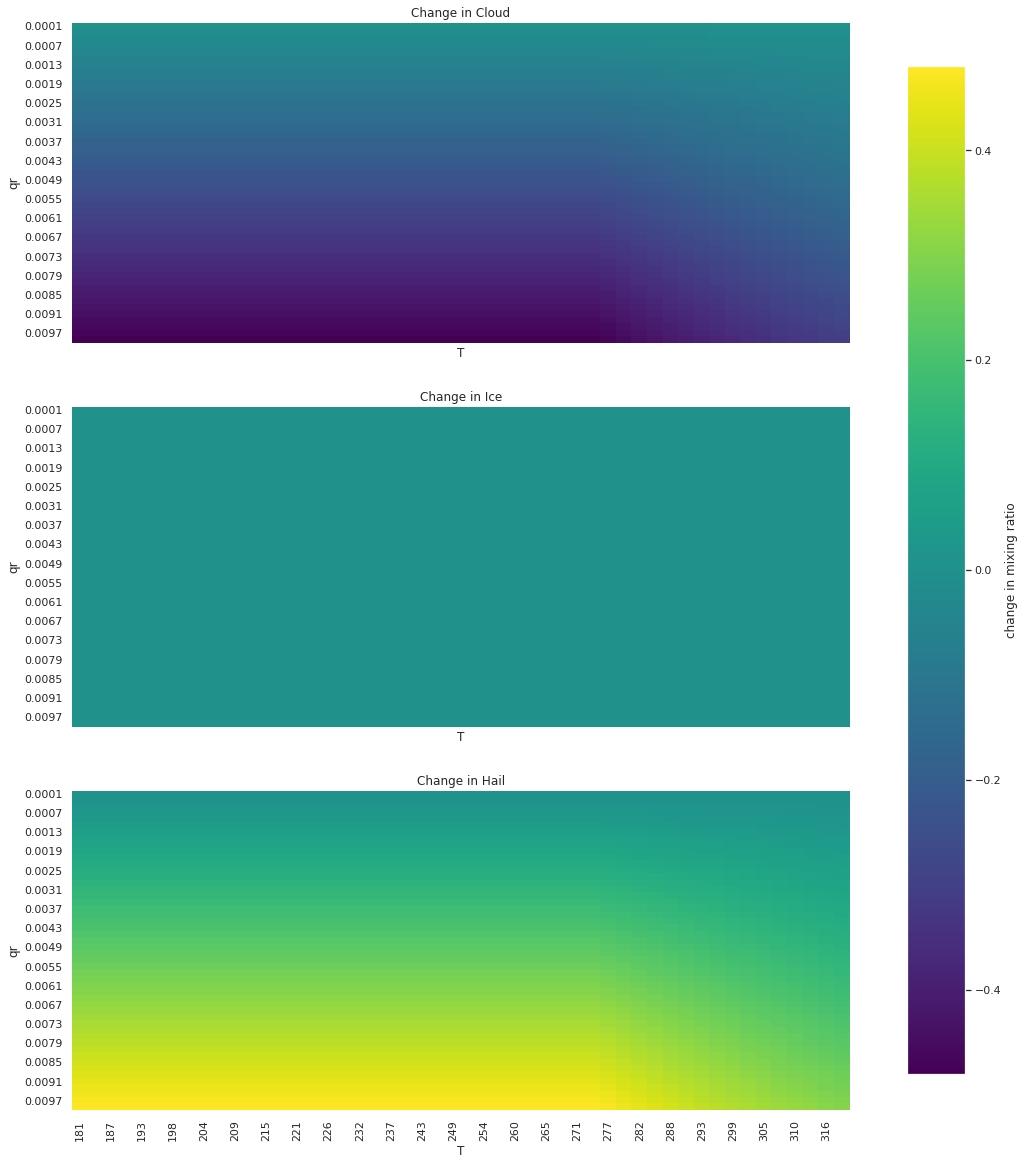

In [7]:
sns.set(rc={'figure.figsize':(16,20)})
cmap = "viridis"

dT = (temp_max - temp_min) / len(df[y].unique())
dqr = (qr_max - qr_min) / len(df[x].unique())
vmin = df[d1].min()
if df["delta_qi"].min() < vmin:
    vmin = df["delta_qi"].min()
if df["delta_qh"].min() < vmin:
    vmin = df["delta_qh"].min()
    
vmax = df[d1].max()
if df["delta_qi"].max() > vmax:
    vmax = df["delta_qi"].max()
if df["delta_qh"].max() > vmax:
    vmax = df["delta_qh"].max()
    
fig, axes = plt.subplots(nrows=3, ncols=1)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh…
sm._A = []
clb = plt.colorbar(sm, cax=cbar_ax)
clb.set_label('change in mixing ratio')

sns.heatmap(df.pivot(x, y, d1), cbar=False, ax=ax1, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax1.set_title("Change in Cloud")

sns.heatmap(df.pivot(x, y, "delta_qi"), cbar=False, ax=ax2, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax2.set_title("Change in Ice")

sns.heatmap(df.pivot(x, y, "delta_qh"), cbar=False, ax=ax3, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=2, yticklabels=3)
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:3.0f}".format(x*dT+temp_min)))
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax3.set_title("Change in Hail")

plt.subplots_adjust(hspace=0.2)
plt.show()

# Plot what happens when all ice melts to rain droplets

In [ ]:
completed = sb.run(
    ["build/apps/src/scratch/scan", "--function", "ice_melting", 
     "--n1", "{}".format(n1), "--n2", "{}".format(n2)] 
    +  method_dic["ice_melting"],
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df.describe()
df

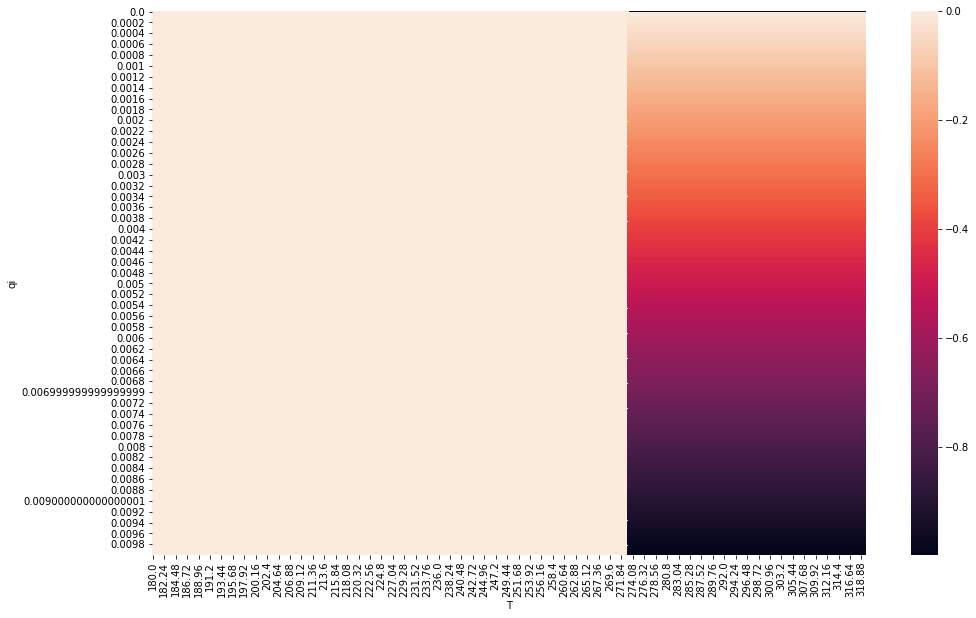

In [3]:

vmin = 0.0001
log_norm = LogNorm(vmin=df["delta_qi"].min()+vmin, vmax=df["delta_qi"].max())

sns.heatmap(df.pivot("qi", "T", "delta_qi"))#, cbar_kws={"ticks": cbar_ticks})

As expected, all ice melts whenever this function is called and a certain temperature is reached

In [8]:
method = "rain_freeze"
n1 = 500
n2 = 500
completed = sb.run(
    ["build/apps/src/scratch/scan", "--function", method, 
     "--n1", "{}".format(n1), "--n2", "{}".format(n2)] 
    +  method_dic[method],
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df.describe()
df

,qr,Nr,T,dt,delta_qr,delta_Nr,delta_qs,delta_Ns,delta_qg,delta_Ng,delta_qh,delta_Nh,delta_lat_cool,delta_lat_heat
0,0.00000,0.0000,180.00,0.01,0.00000,0.0,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0,0.000000
1,0.00002,13.3322,180.00,0.01,-0.00002,0.0,0.000014,19.3715,0.000644,60.94,-0.000639,-66.9794,0,0.000753
2,0.00004,26.6644,180.00,0.01,-0.00004,0.0,0.000029,38.7431,0.001288,121.88,-0.001277,-133.9590,0,0.001505
3,0.00006,39.9965,180.00,0.01,-0.00006,0.0,0.000043,58.1146,0.001932,182.82,-0.001916,-200.9380,0,0.002258
4,0.00008,53.3287,180.00,0.01,-0.00008,0.0,0.000058,77.4861,0.002577,243.76,-0.002554,-267.9170,0,0.003010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.00990,6599.4300,319.72,0.01,0.00000,0.0,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0,0.000000
249996,0.00992,6612.7600,319.72,0.01,0.00000,0.0,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0,0.000000
249997,0.00994,6626.0900,319.72,0.01,0.00000,0.0,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0,0.000000
249998,0.00996,6639.4200,319.72,0.01,0.00000,0.0,0.000000,0.0000,0.000000,0.00,0.000000,0.0000,0,0.000000


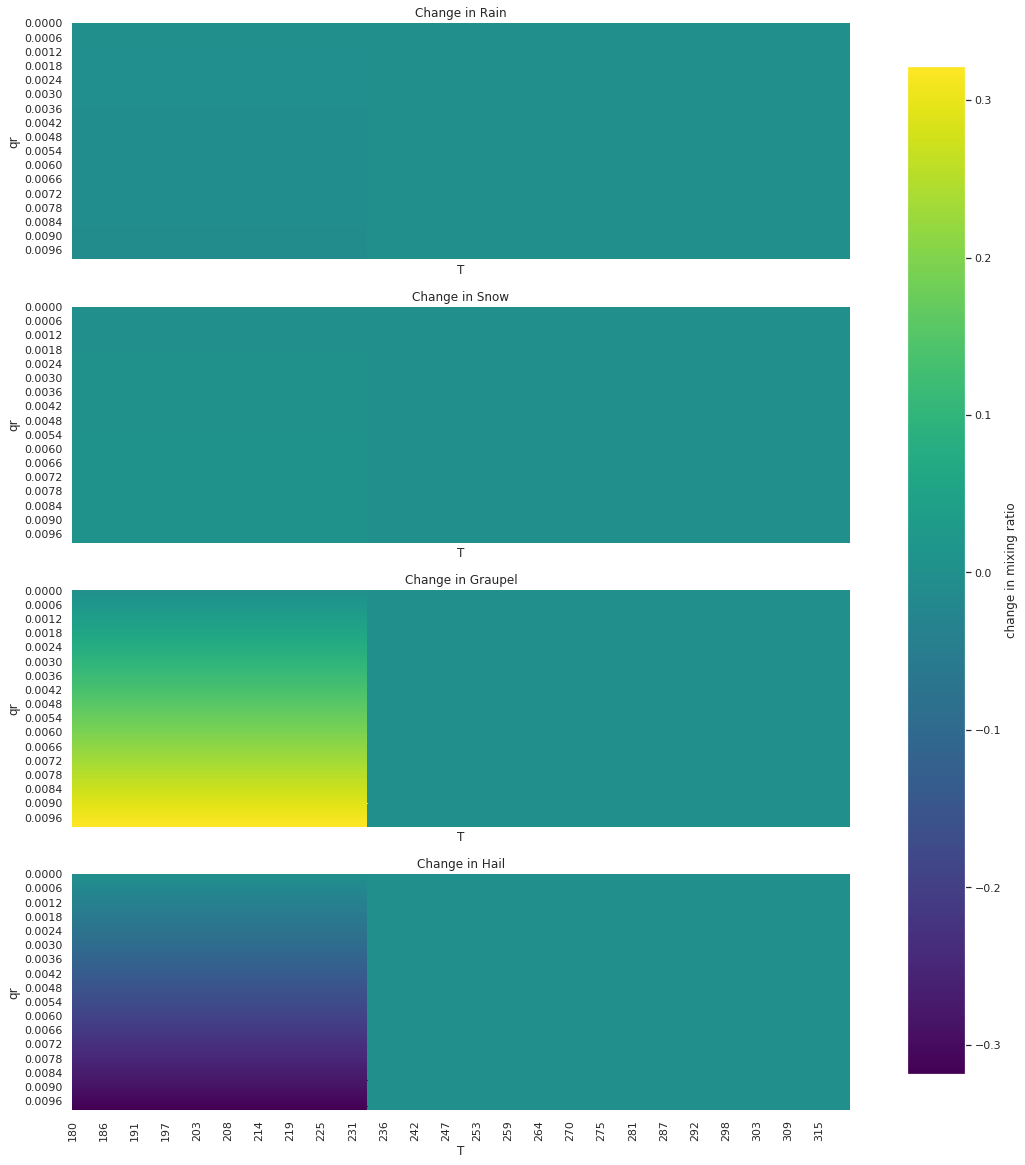

In [9]:
sns.set(rc={'figure.figsize':(16,20)})
cmap = "viridis"
dT = (temp_max - temp_min) / len(df["T"].unique())
dqr = (qr_max - qr_min) / len(df["qr"].unique())
vmin = df["delta_qr"].min()
if df["delta_qs"].min() < vmin:
    vmin = df["delta_qs"].min()
if df["delta_qg"].min() < vmin:
    vmin = df["delta_qg"].min()
if df["delta_qh"].min() < vmin:
    vmin = df["delta_qh"].min()
    
vmax = df["delta_qr"].max()
if df["delta_qs"].max() > vmax:
    vmax = df["delta_qs"].max()
if df["delta_qg"].max() > vmax:
    vmax = df["delta_qg"].max()
if df["delta_qh"].max() > vmax:
    vmax = df["delta_qh"].max()
    
fig, axes = plt.subplots(nrows=4, ncols=1)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
ax4 = axes[3]

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh…
sm._A = []
clb = plt.colorbar(sm, cax=cbar_ax)
clb.set_label('change in mixing ratio')

sns.heatmap(df.pivot("qr", "T", "delta_qr"), cbar=False, ax=ax1, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=30)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax1.set_title("Change in Rain")

sns.heatmap(df.pivot("qr", "T", "delta_qs"), cbar=False, ax=ax2, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=30)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax2.set_title("Change in Snow")

sns.heatmap(df.pivot("qr", "T", "delta_qg"), cbar=False, ax=ax3, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=False, yticklabels=30)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax3.set_title("Change in Graupel")

sns.heatmap(df.pivot("qr", "T", "delta_qh"), cbar=False, ax=ax4, vmin=vmin, vmax=vmax,
                  cmap=cmap, xticklabels=20, yticklabels=30)
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:3.0f}".format(x*dT+temp_min)))
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.4f}".format(x*dqr+qr_min)))
ax4.set_title("Change in Hail")

plt.subplots_adjust(hspace=0.2)
plt.show()

In [2]:
completed = sb.run(
    ["build/apps/src/scratch/scan", 
        "ice_act_phillips", "500", "500", "0", "0.001", "250.0", "270", "0"], 
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df.describe()

,diag,het,inact,Sat_ice,T,qv,delta_n,delta_q
count,2.500000e+05,250000.0,250000.0,250000.000000,250000.000000,250000.000000,250000.000000,2.500000e+05
mean,1.068206e+07,500000.0,0.0,0.351051,259.980000,0.000499,5219.512888,5.219513e-09
std,1.600683e+08,0.0,0.0,0.286426,5.773503,0.000289,50558.418224,5.055842e-08
min,-1.927480e+03,500000.0,0.0,0.000000,250.000000,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,500000.0,0.0,0.136763,254.990000,0.000249,0.000000,0.000000e+00
50%,0.000000e+00,500000.0,0.0,0.274307,259.980000,0.000499,0.000000,0.000000e+00
75%,0.000000e+00,500000.0,0.0,0.488783,264.970000,0.000749,0.000000,0.000000e+00
max,5.465160e+09,500000.0,0.0,1.514660,269.960000,0.000998,500000.000000,5.000000e-07


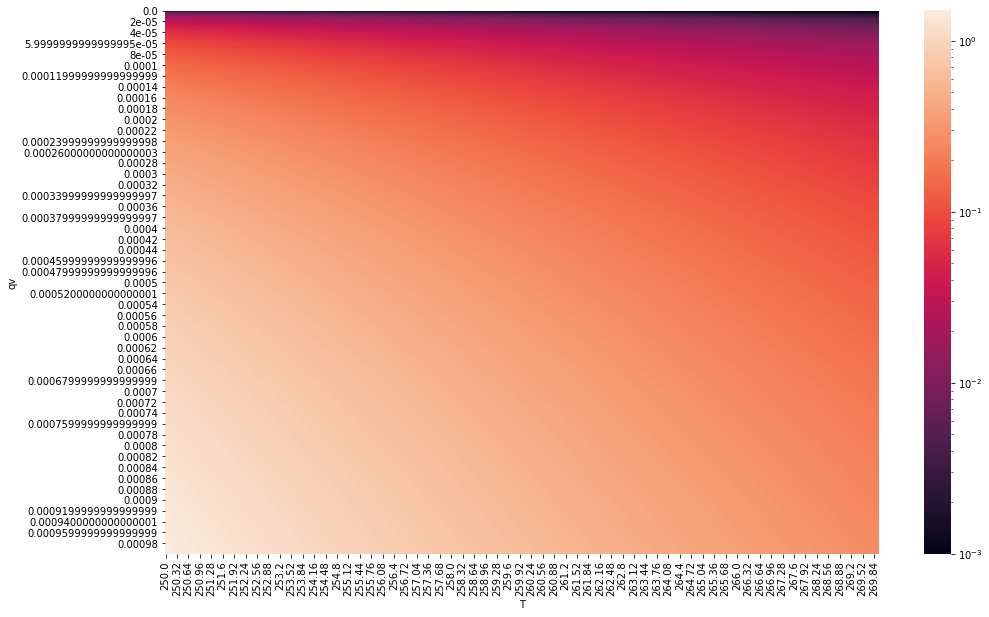

In [3]:
log_norm = LogNorm(vmin=df["Sat_ice"].min()+0.0001, vmax=df["Sat_ice"].max())
# cbar_ticks = [np.power(10, i) for i in 
#               np.arange(np.floor(np.log10(df["Sat_ice"].min()+0.001)), 
#                     1+np.ceil(np.log10(df["Sat_ice"].max())))]

sns.heatmap(df.pivot("qv", "T", "Sat_ice"), norm=log_norm, vmin=0.001)#, cbar_kws={"ticks": cbar_ticks})

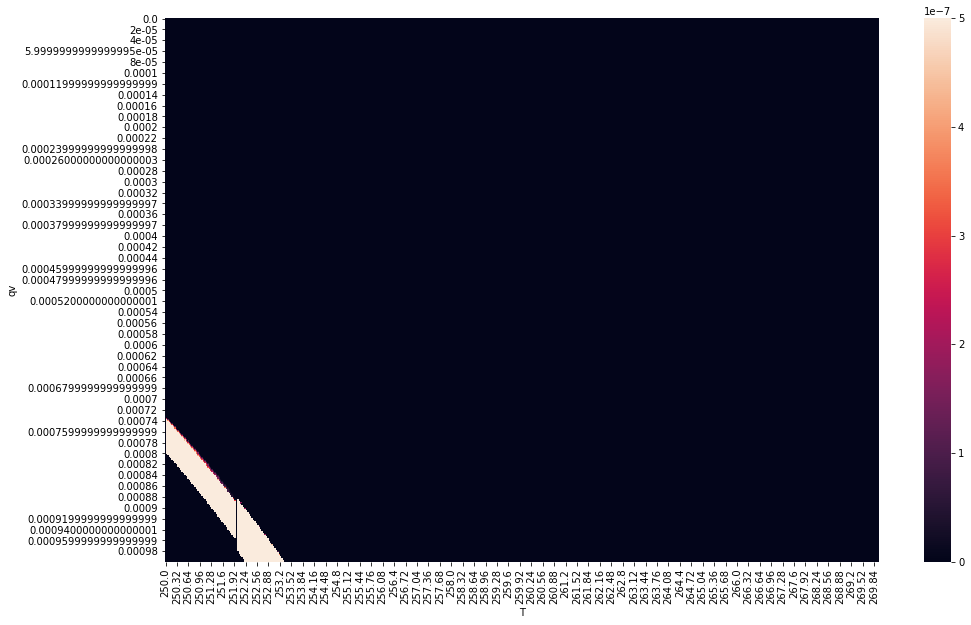

In [4]:
sns.heatmap(df.pivot("qv", "T", "delta_q"))

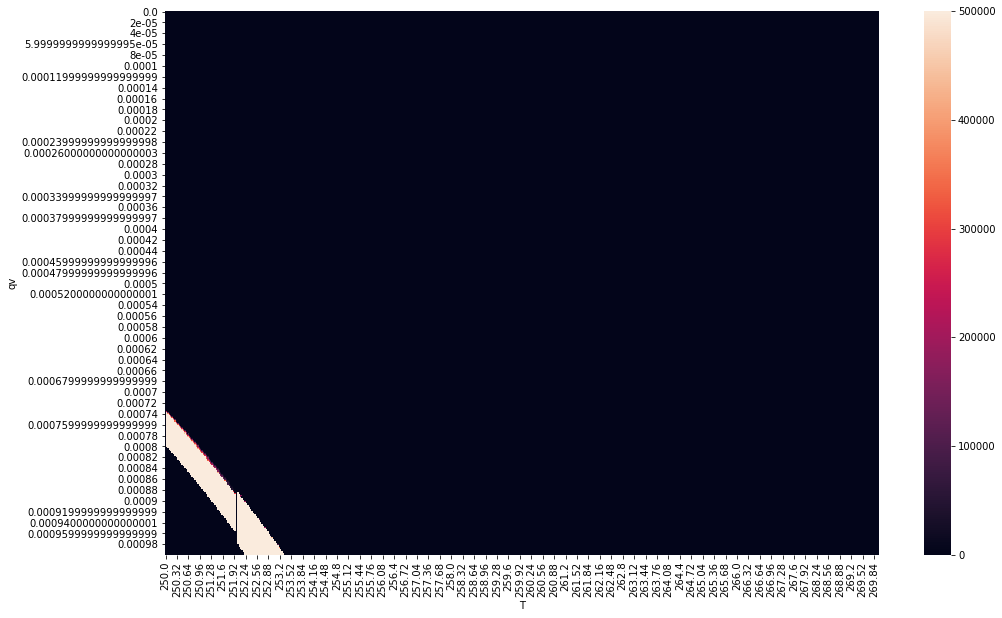

In [5]:
sns.heatmap(df.pivot("qv", "T", "delta_n"))

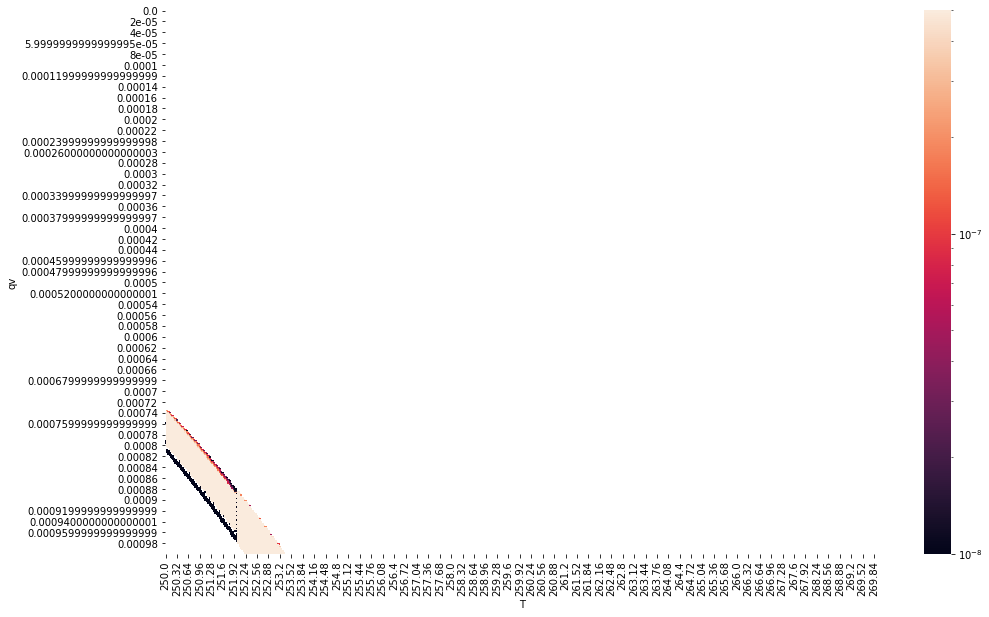

In [6]:
log_norm = LogNorm(vmin=df["delta_q"].min()+0.0001, vmax=df["delta_q"].max())

sns.heatmap(df.pivot("qv", "T", "delta_q"), norm=log_norm, vmin=0.00000001)

In [7]:
%matplotlib widget

fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(df['qv'], df['T'], df['Sat_ice'], cmap=plt.cm.viridis, linewidth=0.2)
# fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
completed = sb.run(
    ["build/apps/src/scratch/scan", 
        "ice_table", "100", "20"], 
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df.describe()

,x,y,dust,soot,orga
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03
mean,49.500000,9.500000,0.000153,0.000002,6.020130e-07
std,28.873289,5.767723,0.000926,0.000038,8.935832e-06
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,24.750000,4.750000,0.000000,0.000000,0.000000e+00
50%,49.500000,9.500000,0.000000,0.000000,0.000000e+00
75%,74.250000,14.250000,0.000000,0.000000,0.000000e+00
max,99.000000,19.000000,0.015800,0.000844,1.990000e-04


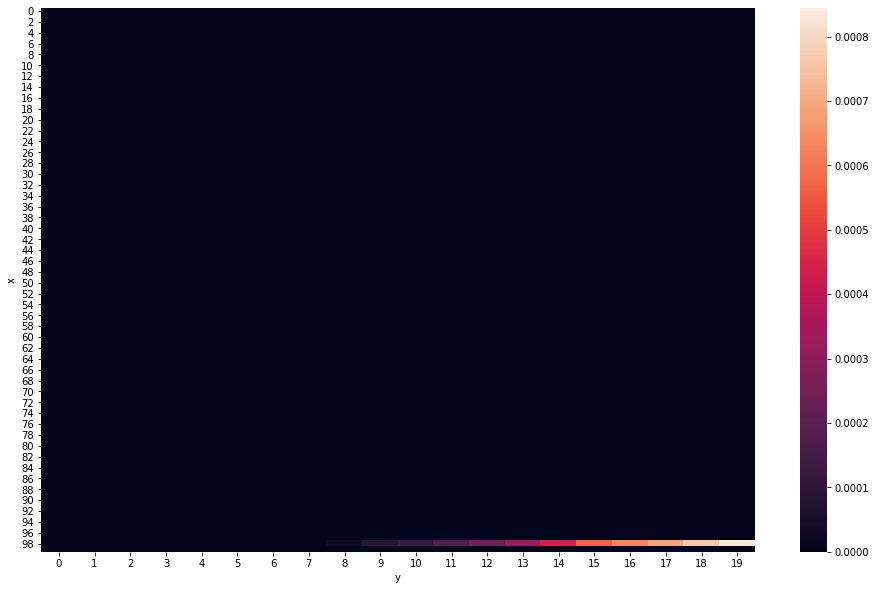

In [6]:
sns.heatmap(df.pivot("x", "y", "soot"))

In [26]:
completed = sb.run(
    ["build/apps/src/scratch/scan", 
        "infrac_scan", "400", "0", "180", "274"], 
    capture_output=True,
    encoding="utf-8")
df = pd.read_csv(StringIO(completed.stdout), sep=",")
df.describe()

,x,y,T,dust,soot,orga
count,400.0,400.000000,400.000000,400.000000,400.000000,4.000000e+02
mean,98.0,20.089419,226.882500,0.021005,0.001167,2.759918e-04
std,0.0,9.630952,27.169361,0.015543,0.000883,2.066856e-04
min,98.0,0.117500,180.000000,0.000000,0.000000,7.410985e-323
25%,98.0,11.838125,203.441250,0.003171,0.000165,3.868412e-05
50%,98.0,23.558750,226.882500,0.022329,0.001217,2.857625e-04
75%,98.0,29.000000,250.323750,0.037300,0.002100,4.950000e-04
max,98.0,29.000000,273.765000,0.037300,0.002100,4.950000e-04


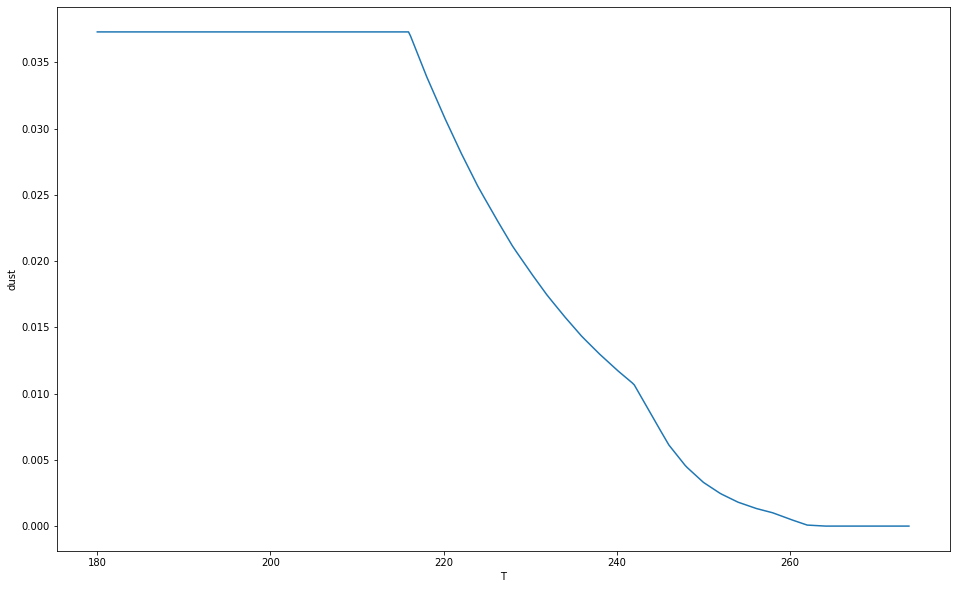

In [27]:
sns.lineplot(x="T", y="dust", data=df)

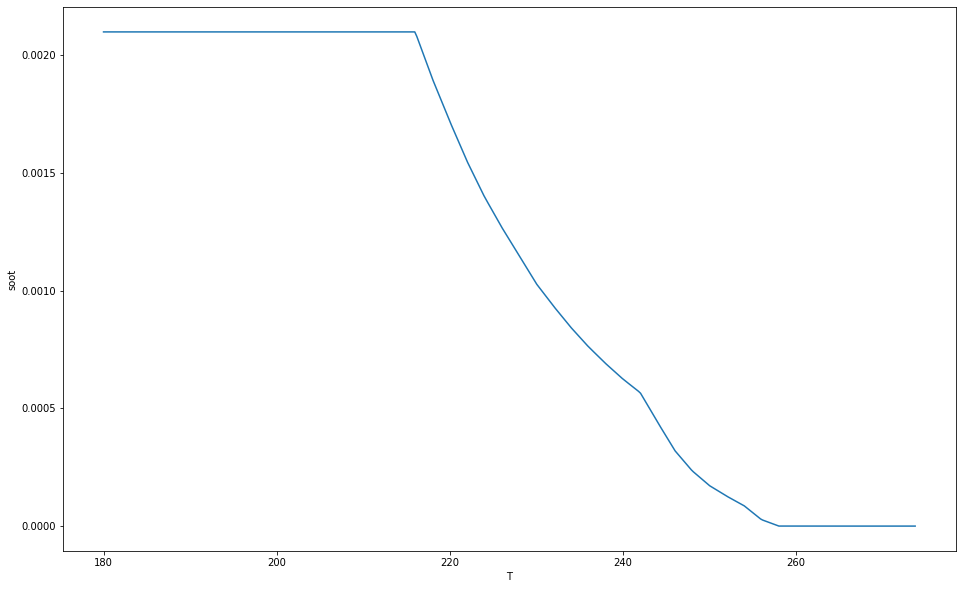

In [28]:
sns.lineplot(x="T", y="soot", data=df)

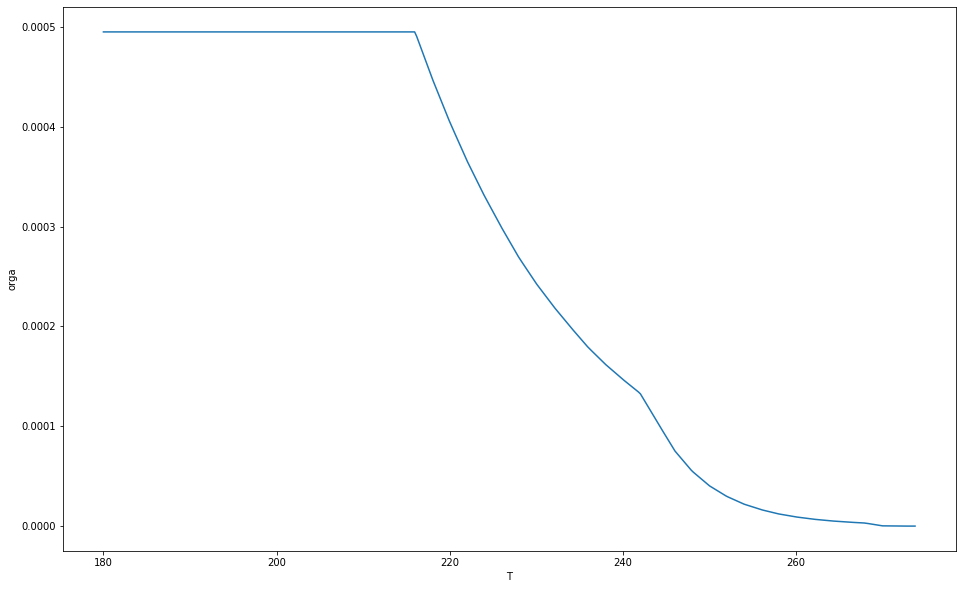

In [29]:
sns.lineplot(x="T", y="orga", data=df)